<a href="https://colab.research.google.com/github/DeepLearningSaeid/Grad/blob/main/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%%capture
# Install Autokeras library
!pip install autokeras

# Import required libraries
import autokeras as ak
import timeit
import numpy as np
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Dense, concatenate, Dropout, Flatten, Activation
from keras import backend as K
from keras.utils import get_custom_objects
from keras.utils import np_utils, to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist


# Set random seed
np.random.seed(110)


In [2]:
# Defining new activation functions
def define_activation_functions():
    """
    Define custom activation functions and update the custom objects dictionary.
    """
    # Define activation functions and their respective names
    activation_functions = [
        ('X_1', lambda x: K.pow(x, 1)),
        ('X_2', lambda x: K.pow(x, 2) / 2),
        ('X_2_', lambda x: K.pow(x, 2) / 24),
        ('X_2__', lambda x: K.pow(x, 2) / 720),
        ('X_2___', lambda x: K.pow(x, 2) / 40320),
        ('X_3', lambda x: K.pow(x, 3) / 6),
        ('X_4', lambda x: K.pow(x, 4) / 24),
        ('X_5', lambda x: K.pow(x, 5) / 120),
        ('X_6', lambda x: K.pow(x, 6) / 720),
        ('X_7', lambda x: K.pow(x, 7) / 5040),
        ('X_8', lambda x: K.pow(x, 8) / 40320),
        ('X_9', lambda x: K.pow(x, 8) / 362880),
    ]

    # Update the custom objects dictionary with the defined activation functions
    for name, function in activation_functions:
        get_custom_objects().update({name: Activation(function)})

# Define and register the custom activation functions
define_activation_functions()


In [3]:
# Create SWAG Model with 4 Layers
def create_swag_model(input_dim, hidden_dim, output_dim, activations):
    """
    Create a SWAG model with two layers of concatenated sub-layers.
    
    Args:
        input_dim (int): The input dimension.
        hidden_dim (int): The hidden dimension.
        output_dim (int): The output dimension.
        activations (list): A list of activation functions for each sub-layer.
        
    Returns:
        model (Model): A Keras model.
    """
    # Define the input layer
    input_layer = Input(shape=(input_dim,))
    
    # Create the first layer with sub-layers using different activation functions
    layer1_sublayers = [Dense(hidden_dim, activation=act)(input_layer) for act in activations]
    
    # Concatenate the first layer's sub-layers
    layer1_concat = concatenate(layer1_sublayers)
    
    # Create a dense layer after concatenation
    layer1_output = Dense(hidden_dim, activation='linear')(layer1_concat)
    
    # Create the second layer with sub-layers using different activation functions
    layer2_sublayers = [Dense(hidden_dim, activation=act)(layer1_output) for act in activations]
    
    # Concatenate the second layer's sub-layers
    layer2_concat = concatenate(layer2_sublayers)
    
    # Create the output layer
    output_layer = Dense(output_dim, activation='linear')(layer2_concat)
    
    # Define the model
    model = Model(input_layer, output_layer)
    
    # Print model summary
    
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

# Define input and hidden dimensions, output dimensions, and activation functions
input_dim = 1
hidden_dim = 50
output_dim = 1
activations = ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8']

# Create the SWAG model
model = create_swag_model(input_dim, hidden_dim , output_dim, activations)


In [4]:
def create_optimized_model(input_dim,  hidden_dim , output_dim ):
    """
    Create an optimized SWAG model with a custom architecture.

    :param input_dim: int, dimension of the input data
    :param output_dim: int, dimension of the output data
    :param hidden_dim: int, hidden layer dimension, default is 50
    :return: Model, a compiled Keras model
    """

    # Define input layer
    input_layer = Input(shape=(input_dim,))

    # First layer with custom activations
    layer_1_x1 = Dense(hidden_dim, activation='X_1')(input_layer)
    layer_1_x2 = Dense(hidden_dim, activation='X_2')(input_layer)
    concat_first_layer = concatenate([layer_1_x1, layer_1_x2])

    # Second layer with custom activations
    layer_x3_x4 = Dense(hidden_dim, activation='X_2_')(concat_first_layer)

    # Third layer with custom activations
    layer_x5_x6 = Dense(hidden_dim, activation='X_2__')(layer_x3_x4)

    # Fourth layer with custom activations
    layer_x7_x8 = Dense(hidden_dim, activation='X_2___')(layer_x5_x6)

    # Concatenate all layers
    concat_second_layer = concatenate([layer_1_x1, layer_1_x2, concat_first_layer,
                                       layer_x3_x4, layer_x5_x6, layer_x7_x8])

    # Output layer for the concatenated layers
    output_first_layer = Dense(hidden_dim, activation='linear')(concat_second_layer)

    # Final output layer
    output_layer = Dense(output_dim, activation='linear')(output_first_layer)

    # Create and compile the model
    model = Model(input_layer, output_layer)
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# Set input and output dimensions
input_dim = 1
output_dim = 1

# Create and compile the optimized model
optimized_model = create_optimized_model(input_dim,hidden_dim, output_dim)
optimized_model = create_swag_model(input_dim, hidden_dim , output_dim, activations)


In [5]:
def power(x, n):
    """
    Raise x to the power of n.

    :param x: float, base number
    :param n: int, exponent
    :return: float, x raised to the power of n
    """
    return np.power(x, n)

def sigmoid_array(x):
    """
    Apply the sigmoid function to the given input.

    :param x: float or array-like, input value(s)
    :return: float or array-like, sigmoid of input value(s)
    """
    return 1 / (1 + np.exp(-x))

def exp(x):
    """
    Calculate the exponential of the given input.

    :param x: float or array-like, input value(s)
    :return: float or array-like, exponential of input value(s)
    """
    return np.exp(x)

def log(x):
    """
    Calculate the natural logarithm of the given input.

    :param x: float or array-like, input value(s)
    :return: float or array-like, natural logarithm of input value(s)
    """
    return np.log(x)

def generate_random(shape_1, shape_2):
    """
    Generate a random matrix with uniform distribution.

    :param shape_1: int, number of rows
    :param shape_2: int, number of columns
    :return: array-like, random matrix of shape (shape_1, shape_2)
    """
    temp = np.random.uniform(low=0.01, high=0.99, size=(shape_1 * shape_2))
    temp1 = temp.reshape(shape_1, shape_2)
    return temp1

def fun_1(x):
    """
    Compute the value of the custom function 1.

    :param x: float or array-like, input value(s)
    :return: float or array-like, result of the custom function 1
    """
    return 1 / 2 * power(x, 2) - 5 * sigmoid_array(x)

def fun_2(x):
    """
    Compute the value of the custom function 2.

    :param x: float or array-like, input value(s)
    :return: float or array-like, result of the custom function 2
    """
    return 6 * power(x, 5) - 3 * sigmoid_array(x) + exp(x) - 9 * log(x)

def fun_3(x):
    """
    Compute the value of the custom function 3.

    :param x: float or array-like, input value(s)
    :return: float or array-like, result of the custom function 3
    """
    return 22 * power(x, 20) + sigmoid_array(x) + 2 * exp(x) + 5 * log(x)


In [6]:
def plot__(history):
    """
    Creates a plot for training and validation loss.
    
    :param history: The history object obtained from training a Keras model.
    """
    # Extract training and validation loss from history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    # Create a range for the number of epochs
    epoch_count = range(1, len(training_loss) + 1)
    
    # Plot the training and validation loss
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, validation_loss, 'b-')
    
    # Add legend, labels, and title
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    
    # Show the plot
    plt.show()


In [7]:


def plot_loss(size, in_1, in_2, in_3, in_4, in_5):
    # Set font size for all subplots
    plt.rcParams.update({'font.size': 12})
    
    def plot_subplot(subplot_num, history, title):
        # Extract training and test loss from history object
        training_loss = history.history['loss']
        test_loss = history.history['val_loss']
        
        # Create list of epochs
        epoch_count = range(1, len(training_loss) + 1)
        
        # Create subplot and plot training and test loss
        plt.subplot(subplot_num)
        plt.plot(epoch_count, training_loss, 'r--')
        plt.plot(epoch_count, test_loss, 'b-')
        
        # Add legend and labels
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        # Set y-axis limit
        plt.ylim(0, size)
        
        # Add title to subplot
        plt.title(title)
    
    # Create figure with 6 subplots
    plt.figure(figsize=(20, 12))
    
    # Plot training and test loss for each model architecture
    plot_subplot(231, in_1, 'Architecture 1')
    plot_subplot(232, in_2, 'Architecture 2')
    plot_subplot(233, in_3, 'Auto_Keras ')
    plot_subplot(234, in_4, 'Random Search')
    plot_subplot(235, in_5, 'SWAG')



def plot_shape(in_1,in_2,in_3,in_4,in_5):
    # Set up the plot with a figure size of (20,10)
    plt.figure(figsize=(20,10))
    # Update the font size of the plot to 16
    plt.rcParams.update({'font.size': 16})

    # Plot the first subplot with the input data
    plt.subplot(231)
    plt.scatter(in_1[0], in_1[1])
    plt.scatter(in_1[0], in_1[2])
    plt.title('Architure 1')

    # Plot the second subplot with the input data
    plt.subplot(232)
    plt.scatter(in_2[0], in_2[1])
    plt.scatter(in_2[0], in_2[2])
    plt.title('Architure 2')

    # Plot the third subplot with the input data
    plt.subplot(233)
    plt.scatter(in_3[0], in_3[1])
    plt.scatter(in_3[0], in_3[2])
    plt.title('Auto Keras')

    # Plot the fourth subplot with the input data
    plt.subplot(234)
    plt.scatter(in_4[0], in_4[1])
    plt.scatter(in_4[0], in_4[2])
    plt.title('Random Search')
    
    # Plot the fifth subplot with the input data
    plt.subplot(235)
    plt.scatter(in_5[0], in_5[1])
    plt.scatter(in_5[0], in_5[2])
    plt.title('SWAG')    
    

    # Adjust the subplot layout
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0010, right=0.95, hspace=0.3, wspace=0.18)

    # Show the plot
    plt.show()


In [8]:
def plot_loss(history):
    """
    Plot the training and test loss using the history object.

    :param history: History object, training history of the model
    """
    # Retrieve the training and test loss values
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Generate epoch count
    epoch_count = range(1, len(training_loss) + 1)

    # Plot the training and test loss
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def visualize_results(history, X_test, Y_test, model):
    """
    Visualize the results of a trained model by plotting the loss curve and comparing true
    test data with the model's predicted output.

    :param history: History object, training history of the model
    :param X_test: array-like, test input data
    :param Y_test: array-like, test output data (true values)
    :param model: trained model to visualize
    """
    # Plot the loss curve
    plot_loss(history)
    
    # Scatter plot of the true test data
    plt.scatter(X_test, Y_test, label='True data')
    
    # Scatter plot of the model's predicted output
    predictions = model.predict(X_test)
    plt.scatter(X_test, predictions, label='Predicted data')

    plt.legend()
    plt.show()


In [9]:
def visualize_predictions(data_list, title_list):
    """
    Visualize the predictions for multiple model architectures.

    :param data_list: list, list of tuples containing test input data, test output data (true values),
                      and model predictions for each model architecture
    :param title_list: list, list of titles corresponding to each model architecture
    """
    # Set up the plot with a figure size of (20,10)
    plt.figure(figsize=(20, 10))

    # Update the font size of the plot to 16
    plt.rcParams.update({'font.size': 16})

    # Plot the subplots with the input data
    for i, (data, title) in enumerate(zip(data_list, title_list), start=1):
        X_test = data[0]
        Y_test = data[1]
        predictions = data[2]
        
        plt.subplot(2, 3, i)
        plt.scatter(X_test, Y_test, label='Actual')
        plt.scatter(X_test, predictions, label='Predicted')
        plt.title(title)
        plt.legend()

    # Adjust the subplot layout
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.3)

    # Show the plot
    plt.show()


# Example usage



In [10]:
#Creates dataset
dim_train=1000
dim_test=200

X=generate_random(dim_train,3)
Y=generate_random(dim_train,3)
    
Y[:,0]=fun_1(X[:,0])
Y[:,1]=fun_2(X[:,1])
Y[:,2]=fun_3(X[:,2])
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=1234)

def data_prep(x_train,x_test,y_train,y_test,column):
  X_train=x_train[:,column]
  Y_train=y_train[:,column]
  X_test=x_test[:,column]
  Y_test=y_test[:,column]
  return X_train,Y_train,X_test,Y_test

In [11]:
def visualize_loss(size, hist_list, title_list):
    """
    Visualize the training and test losses for multiple model architectures.

    :param size: int, y-axis limit for loss values
    :param hist_list: list, list of Keras history objects for each model architecture
    :param title_list: list, list of titles corresponding to each model architecture
    """
    # Set font size for all subplots
    plt.rcParams.update({'font.size': 12})

    def plot_subplot(subplot_num, history, title):
        # Extract training and test loss from history object
        training_loss = history.history['loss']
        test_loss = history.history['val_loss']

        # Create list of epochs
        epoch_count = range(1, len(training_loss) + 1)

        # Create subplot and plot training and test loss
        plt.subplot(subplot_num)
        plt.plot(epoch_count, training_loss, 'r--')
        plt.plot(epoch_count, test_loss, 'b-')

        # Add legend and labels
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        # Set y-axis limit
        plt.ylim(0, size)

        # Add title to subplot
        plt.title(title)

    # Create figure with subplots
    plt.figure(figsize=(20, 12))

    # Plot training and test loss for each model architecture
    for i, (history, title) in enumerate(zip(hist_list, title_list), start=1):
        plot_subplot(int(f"23{i}"), history, title)

    # Adjust the subplot layout
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0010, right=0.95, hspace=0.3, wspace=0.18)

    # Show the plot
    plt.show()

In [12]:
def train_and_visualize_model(model, X_train, Y_train, X_test, Y_test, num_epochs, batch_size):
    """
    Train a given model and visualize its results using the provided training and testing data.

    :param model: the model to train and visualize
    :param X_train: array-like, training input data
    :param Y_train: array-like, training output data (true values)
    :param X_test: array-like, test input data
    :param Y_test: array-like, test output data (true values)
    :param num_epochs: int, number of epochs for training
    :param batch_size: int, batch size for training
    :return: list, containing test input data, test output data (true values), model predictions, and training history
    """
    # Train the model
    start = timeit.default_timer()
    history = model.fit(X_train, Y_train, epochs=num_epochs, verbose=0, batch_size=batch_size,
                        validation_data=(X_test, Y_test))
    end = timeit.default_timer()
    print("Run Time : %f" % (end - start))

    # Make predictions and visualize results
    predictions = model.predict(X_test)
    visualize_results(history, X_test, Y_test, model)

    return [X_test, Y_test, predictions, history]


In [13]:
# Hyper perameters
number_epo=5
input_dim=1
output_dim=1

In [14]:

hidden_dimention = 50

Our_model=create_swag_model(input_dim, hidden_dim , output_dim, activations)
# Our_model=create_optimized_model(input_dim,hidden_dim ,output_dim)


#Train the Model

Run Time : 12.885176
7/7 [==============================] - 0s 3ms/step


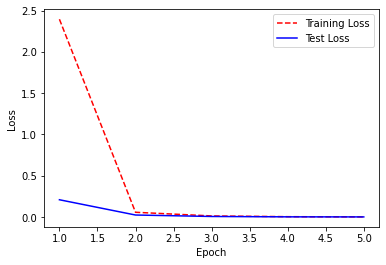

7/7 [==============================] - 0s 4ms/step


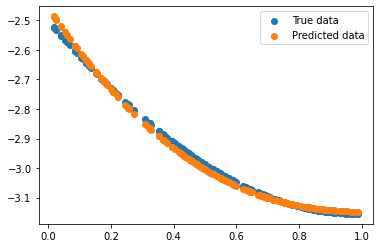

Run Time : 2.283424
7/7 [==============================] - 0s 2ms/step


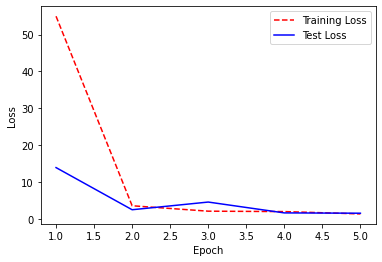

7/7 [==============================] - 0s 2ms/step


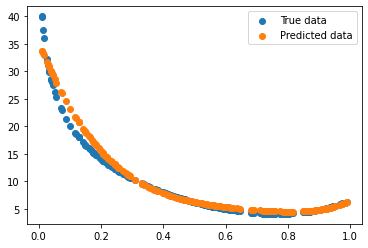

Run Time : 2.158632
7/7 [==============================] - 0s 2ms/step


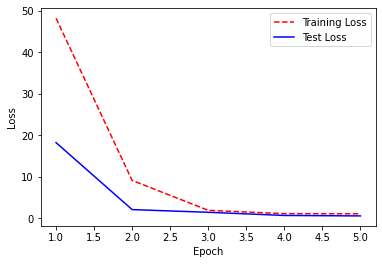

7/7 [==============================] - 0s 2ms/step


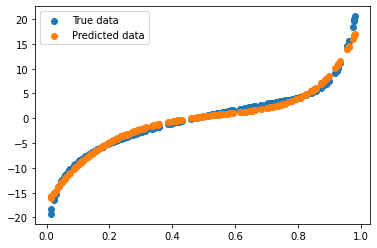

In [15]:
# this code is preparing data, training a model, and then visualizing the results of the model's performance. 
# The data preparation includes reshaping the data into the correct shape for the model and selecting a particular column of the data to use. 
# The model is then trained on this data for a specified number of epochs, and the time it takes to train the model is recorded.
# Finally, the model is used to make predictions on the test set, and the results are visualized.
#   The results of the model's performance, including the test data and predictions, are stored in the F_1_our_model variable.

# Preprocess data
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_our_model = train_and_visualize_model(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)


# Preprocess data
column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# Train model

F_2_our_model = train_and_visualize_model(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)


# Preprocess data
column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# Train model

F_3_our_model = train_and_visualize_model(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)

In [16]:
#Second Traditional model for Function 3
archicture_1 = Sequential()
archicture_1.add(Dense(5, input_dim=input_dim, activation='relu'))
archicture_1.add(Dense(10, activation='relu'))
archicture_1.add(Dense(50, activation='tanh'))
archicture_1.add(Dense(18, activation='relu'))
archicture_1.add(Dense(15, activation='tanh'))
archicture_1.add(Dense(18, activation='sigmoid'))
archicture_1.add(Dropout(0.2))
archicture_1.add(Dense(8, activation='relu'))
archicture_1.add(Dropout(0.2))
archicture_1.add(Dense(output_dim, activation='relu'))
#model.summary()
archicture_1.compile(loss='mean_squared_error', optimizer='adam')

Run Time : 4.465523
7/7 [==============================] - 0s 2ms/step


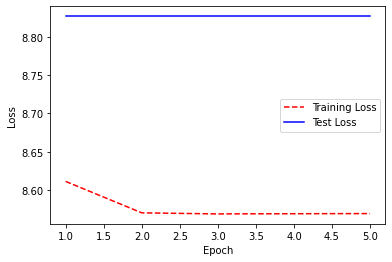

7/7 [==============================] - 0s 2ms/step


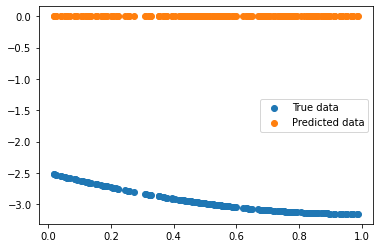

Run Time : 1.405091
7/7 [==============================] - 0s 2ms/step


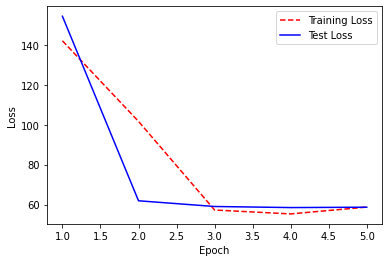

7/7 [==============================] - 0s 2ms/step


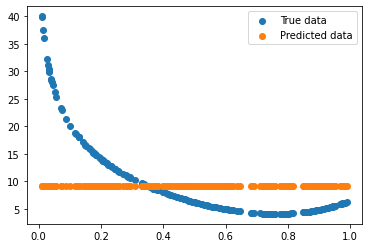

Run Time : 1.402159
7/7 [==============================] - 0s 2ms/step


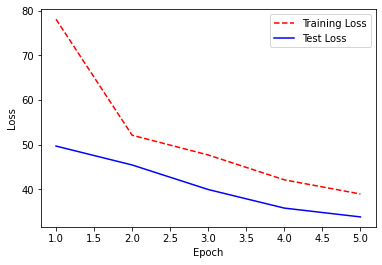

7/7 [==============================] - 0s 2ms/step


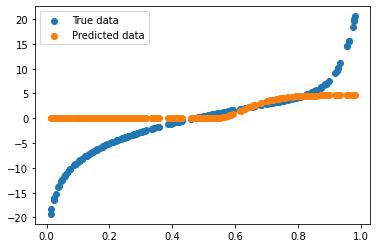

In [17]:
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_archicture_1 = train_and_visualize_model(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_archicture_1 = train_and_visualize_model(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_archicture_1 = train_and_visualize_model(archicture_1,X_train,Y_train,X_test,Y_test,number_epo,10)

In [18]:
#Fifth Traditional Model
archicture_2 = Sequential()
archicture_2.add(Dense(5, input_dim=input_dim, activation='softplus'))
archicture_2.add(Dense(10, activation='softplus'))
archicture_2.add(Dense(20, activation='tanh'))
archicture_2.add(Dense(15, activation='relu'))
archicture_2.add(Dense(25, activation='tanh'))
archicture_2.add(Dense(20, activation='sigmoid'))
archicture_2.add(Dense(25, activation='relu'))
archicture_2.add(Dense(output_dim, activation='softplus'))
archicture_2.add(Dropout(0.2))
archicture_2.compile(loss='mean_squared_error', optimizer='adam')

Run Time : 4.031004
7/7 [==============================] - 0s 2ms/step


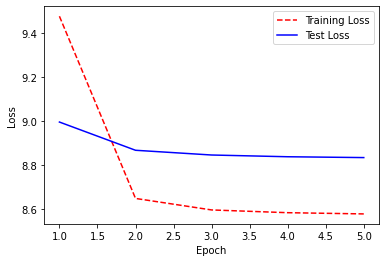

7/7 [==============================] - 0s 2ms/step


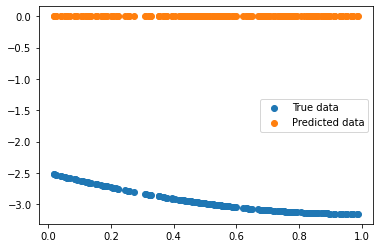

Run Time : 1.351386
7/7 [==============================] - 0s 2ms/step


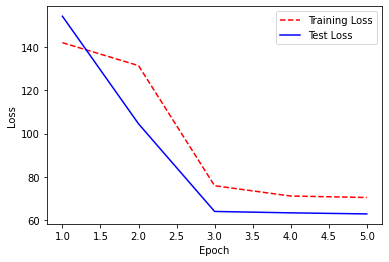

7/7 [==============================] - 0s 2ms/step


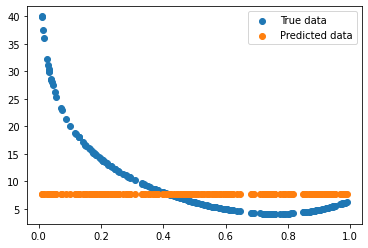

Run Time : 1.383607
7/7 [==============================] - 0s 2ms/step


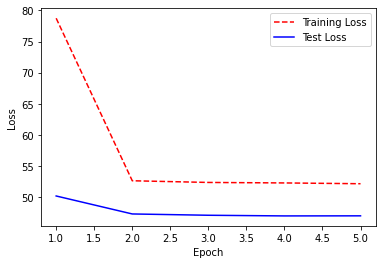

7/7 [==============================] - 0s 2ms/step


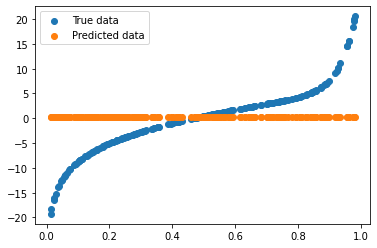

In [19]:
column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_archicture_2 = train_and_visualize_model(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_archicture_2 = train_and_visualize_model(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_archicture_2 = train_and_visualize_model(archicture_2,X_train,Y_train,X_test,Y_test,number_epo,10)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Run Time : 2.693408
7/7 [==============================] - 0s 2ms/step


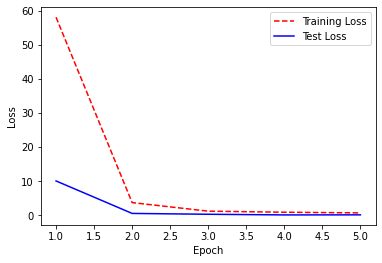

7/7 [==============================] - 0s 2ms/step


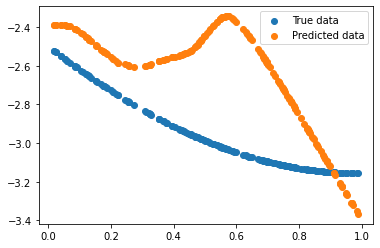

Run Time : 1.201229
7/7 [==============================] - 0s 2ms/step


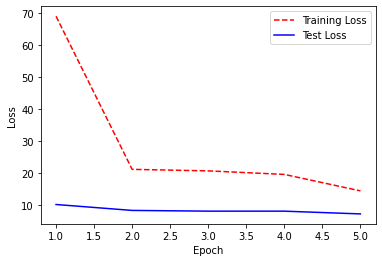

7/7 [==============================] - 0s 2ms/step


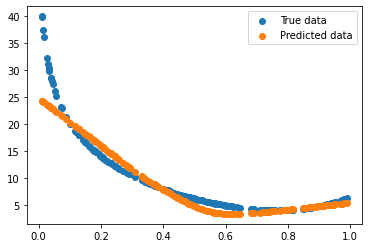

Run Time : 1.215771
7/7 [==============================] - 0s 2ms/step


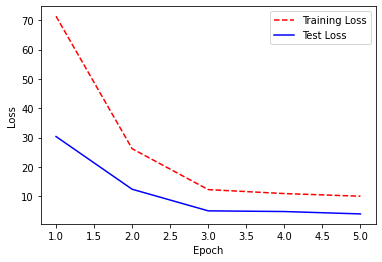

7/7 [==============================] - 0s 2ms/step


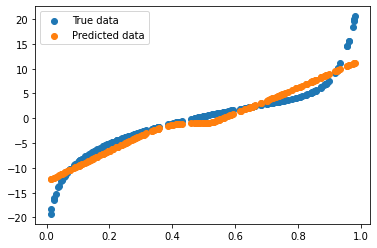

In [20]:
column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_set = tf.data.Dataset.from_tensor_slices(
    (X_test, Y_test)
)

clf = ak.StructuredDataRegressor(
    overwrite=True, max_trials=10
) 
# Feed the tensorflow Dataset to the classifier.
clf.fit(train_set, epochs=5,verbose=0)
autokeras_model=clf.export_model()


column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_autokeras = train_and_visualize_model(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_autokeras = train_and_visualize_model(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_autokeras = train_and_visualize_model(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)

In [21]:
def create_optimal_model(best_param):
    """
    Create the optimal model using the best parameters obtained from GridSearchCV.

    :param best_param: dict, best parameters obtained from GridSearchCV
    :return: Keras model
    """

    model = Sequential()
    
    # Add the first layer with the best parameters
    model.add(Dense(best_param['neuron1'], input_dim=1, kernel_initializer=best_param['init'], activation=best_param['activation_function']))
    
    # Add the first dropout layer with the best dropout rate
    model.add(Dropout(best_param['dropout_rate']))
    
    # Add the second layer with the best parameters
    model.add(Dense(best_param['neuron2'], input_dim=best_param['neuron1'], kernel_initializer=best_param['init'], activation=best_param['activation_function_1']))
    
    # Add the second dropout layer with the best dropout rate
    model.add(Dropout(best_param['dropout_rate']))
    
    # Add the output layer with the best activation function
    model.add(Dense(1, activation=best_param['activation_function_2']))

    # Compile the model using Adam optimizer with the best learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_param['learning_rate'])
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mse'])
    
    return model


In [22]:
def create_custom_model(learning_rate, dropout_rate, activation_function, activation_function_1, activation_function_2, init, neuron1, neuron2):
    """
    Create a Keras model with custom hyperparameters.

    :param learning_rate: float, learning rate for the optimizer
    :param dropout_rate: float, dropout rate for the Dropout layers
    :param activation_function: str, activation function for the first layer
    :param activation_function_1: str, activation function for the second layer
    :param activation_function_2: str, activation function for the output layer
    :param init: str, kernel initializer
    :param neuron1: int, number of neurons in the first layer
    :param neuron2: int, number of neurons in the second layer
    :return: Keras model
    """

    model = Sequential()
    model.add(Dense(neuron1, input_dim=1, kernel_initializer=init, activation=activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron2, input_dim=neuron1, kernel_initializer=init, activation=activation_function_1))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation_function_2))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['mse'])
    return model

# Create the model
model = KerasRegressor(build_fn=create_custom_model, verbose=0)

# Define the grid search parameters
param_grids = {
    'batch_size': [10],
    'epochs': [number_epo],
    'learning_rate': [0.01],
    'dropout_rate': [0.1],
    'activation_function': ['softmax', 'relu', 'tanh', 'linear'],
    'activation_function_1': ['softmax', 'relu', 'tanh', 'linear'],
    'activation_function_2': ['softmax', 'relu', 'tanh', 'linear'],
    'init': ['uniform'],
    'neuron1': [50, 100, 150],
    'neuron2': [20, 40, 80],
}

start = timeit.default_timer()

# Build and fit the GridSearchCV
kfold = KFold(n_splits=2)
grid = GridSearchCV(estimator=model, param_grid=param_grids, cv=kfold, verbose=0)
grid_result = grid.fit(X_train, Y_train)

# Summarize the results
print(f"Best score: {grid_result.best_score_}, using {grid_result.best_params_}")
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean}, {stdev} with: {param}")

# Print runtime
end = timeit.default_timer()
print("Run Time : %f" % (end-start))


<ipython-input-22-5c3ae7af6c2a>:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_custom_model, verbose=0)


Best score: -4.564665794372559, using {'activation_function': 'tanh', 'activation_function_1': 'relu', 'activation_function_2': 'linear', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 5, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 150, 'neuron2': 80}
-52.99837684631348, 0.8944072723388672 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 5, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 50, 'neuron2': 20}
-52.99837684631348, 0.8944072723388672 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate': 0.1, 'epochs': 5, 'init': 'uniform', 'learning_rate': 0.01, 'neuron1': 50, 'neuron2': 40}
-52.99837684631348, 0.8944072723388672 with: {'activation_function': 'softmax', 'activation_function_1': 'softmax', 'activation_function_2': 'softmax', 'batch_size': 10, 'dropout_rate':

In [23]:
search_model=create_optimal_model(grid_result.best_params_) 

Run Time : 2.188547
7/7 [==============================] - 0s 1ms/step


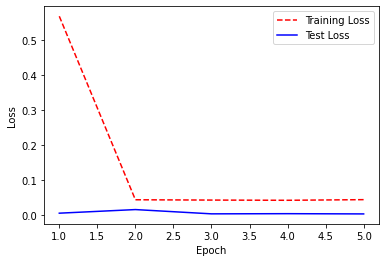

7/7 [==============================] - 0s 2ms/step


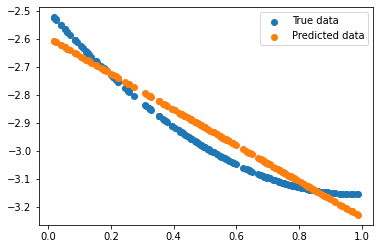

Run Time : 1.093942
7/7 [==============================] - 0s 2ms/step


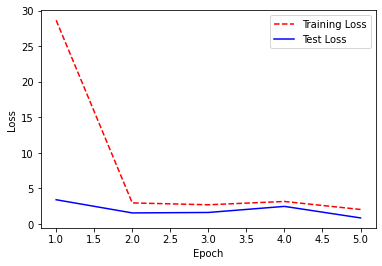

7/7 [==============================] - 0s 2ms/step


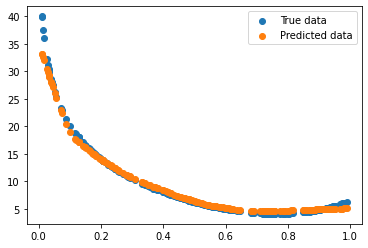

Run Time : 1.095872
7/7 [==============================] - 0s 2ms/step


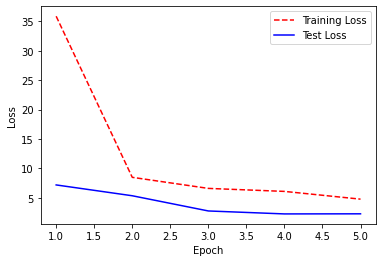

7/7 [==============================] - 0s 2ms/step


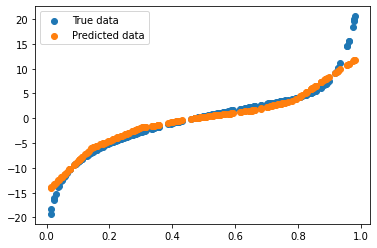

In [24]:



column = 0
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_1_Search = train_and_visualize_model(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 1
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_2_Search = train_and_visualize_model(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

column = 2
X_train, Y_train, X_test, Y_test = data_prep(x_train, x_test, y_train, y_test, column)

# Reshape data
X_train = X_train.reshape(800, 1)
Y_train = Y_train.reshape(800, 1)
X_test = X_test.reshape(200, 1)
Y_test = Y_test.reshape(200, 1)

# # Train model
F_3_Search = train_and_visualize_model(search_model,X_train,Y_train,X_test,Y_test,number_epo,10)

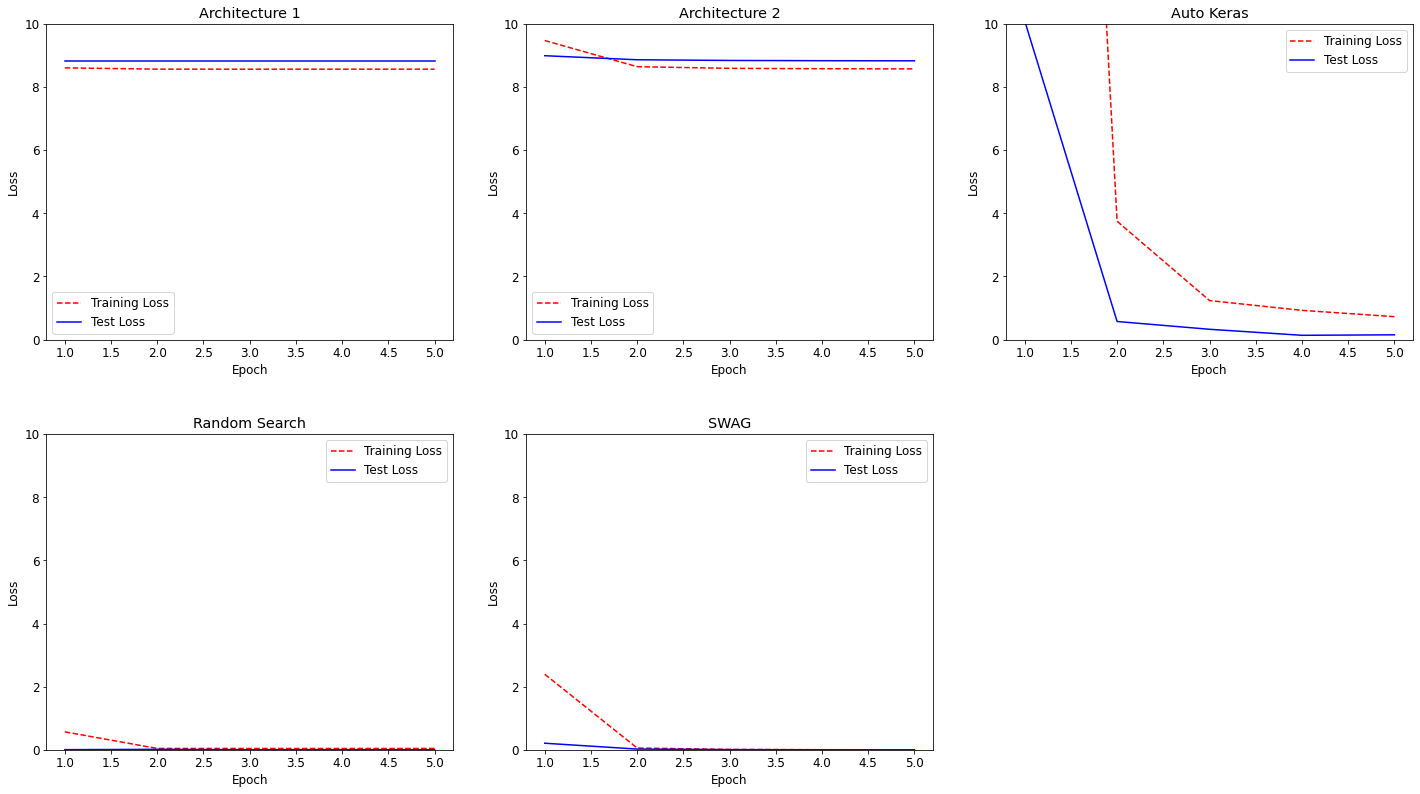

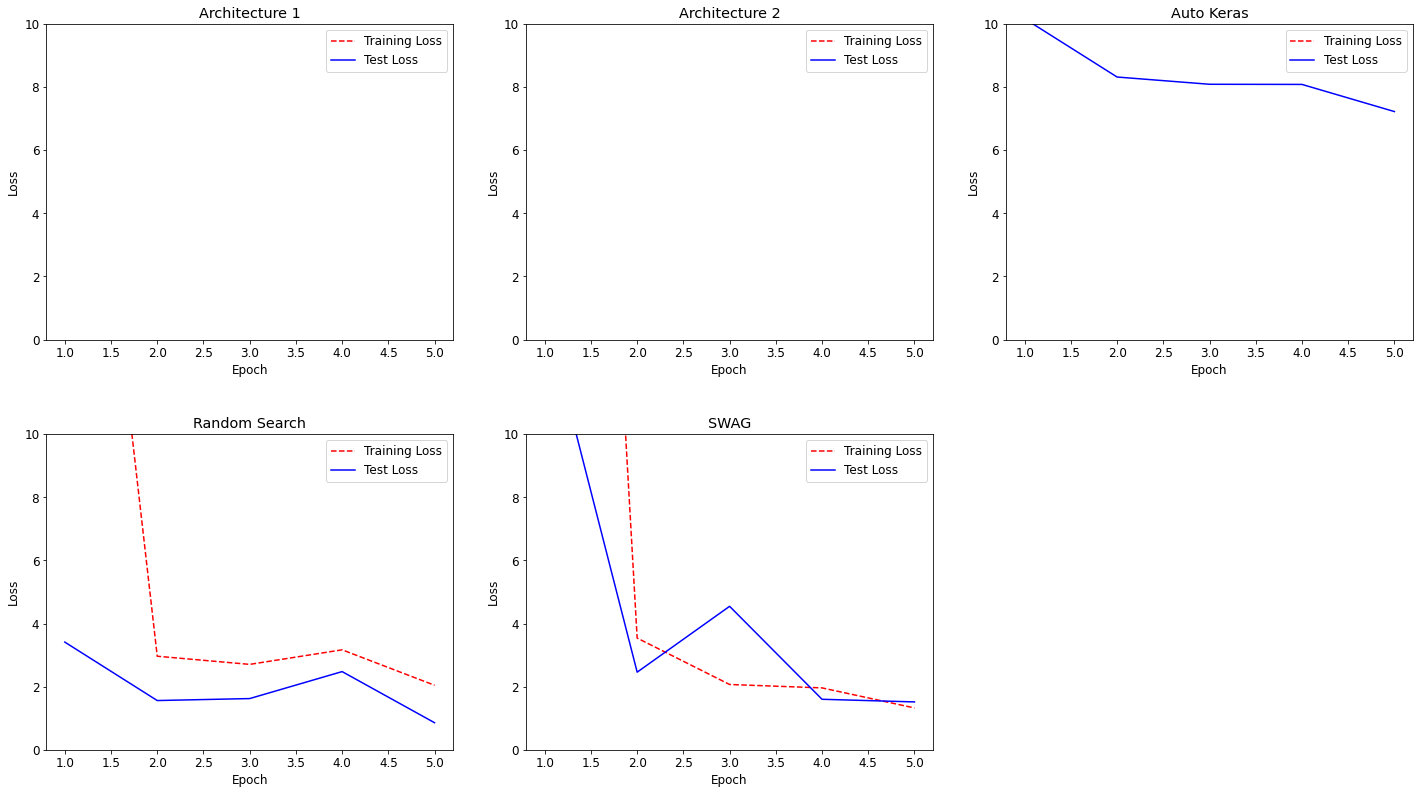

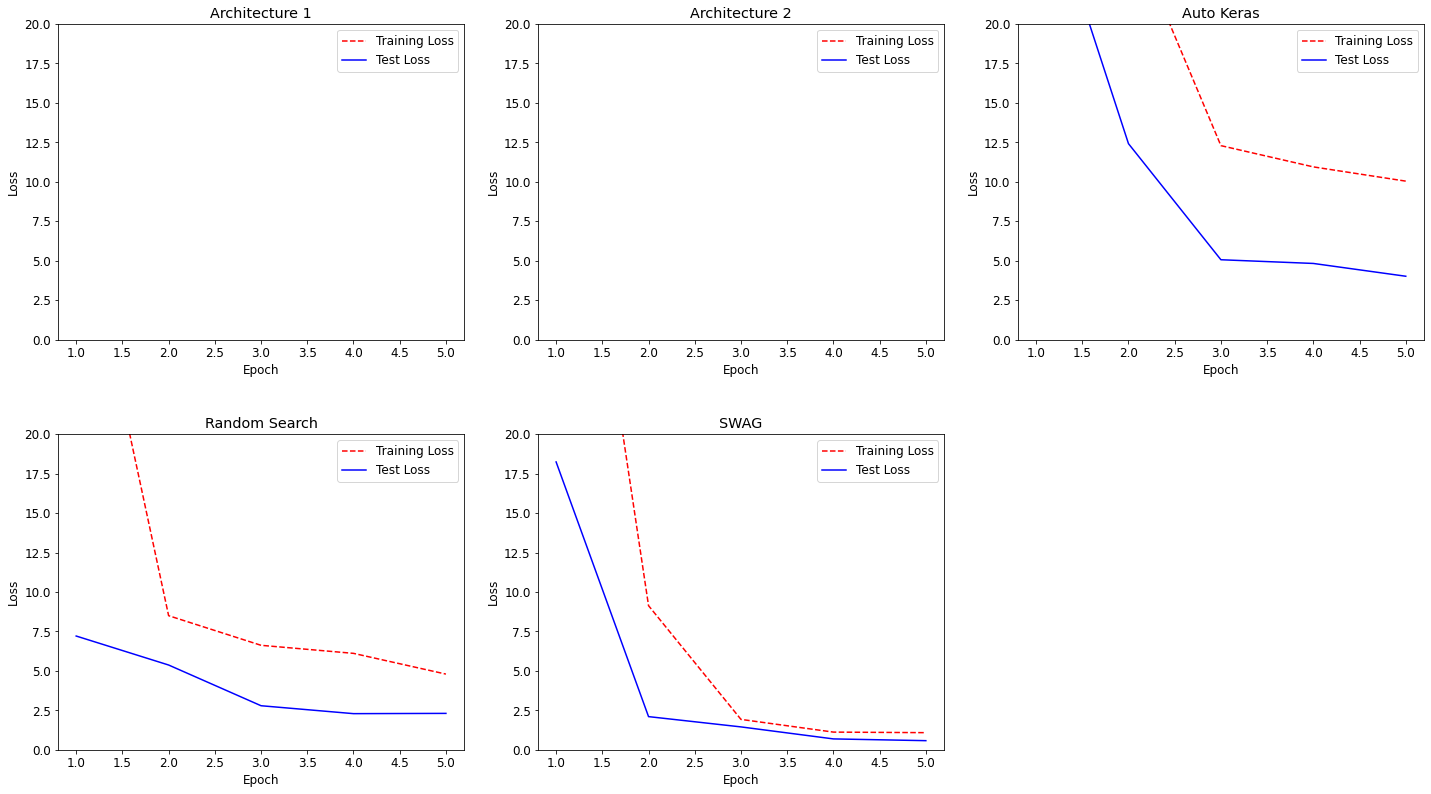

In [25]:

# Example usage
visualize_loss(10, [F_1_archicture_1[3], F_1_archicture_2[3], F_1_autokeras[3], F_1_Search[3], F_1_our_model[3]],
               ['Architecture 1', 'Architecture 2', 'Auto Keras', 'Random Search', 'SWAG'])

visualize_loss(10, [F_2_archicture_1[3], F_2_archicture_2[3], F_2_autokeras[3], F_2_Search[3], F_2_our_model[3]],
               ['Architecture 1', 'Architecture 2', 'Auto Keras', 'Random Search', 'SWAG'])

visualize_loss(20, [F_3_archicture_1[3], F_3_archicture_2[3], F_3_autokeras[3], F_3_Search[3], F_3_our_model[3]],
               ['Architecture 1', 'Architecture 2', 'Auto Keras', 'Random Search', 'SWAG'])


In [26]:
def print_loss_values(fold_name, model_list):
    print(f'@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    print(f'Loss Value of {fold_name}')
    for model in model_list:
        loss_history = model.history['loss']
        rounded__ = [round(num, 7) for num in loss_history]
        print(rounded__)

models_F1 = [
    F_1_archicture_1[3], F_1_archicture_2[3], F_1_autokeras[3], F_1_Search[3], F_1_our_model[3]
]
models_F2 = [
    F_2_archicture_1[3], F_2_archicture_2[3], F_2_autokeras[3], F_2_Search[3], F_2_our_model[3]
]
models_F3 = [
    F_3_archicture_1[3], F_3_archicture_2[3], F_3_autokeras[3], F_3_Search[3], F_3_our_model[3]
]

print_loss_values('F1', models_F1)
print_loss_values('F2', models_F2)
print_loss_values('F3', models_F3)


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Loss Value of F1
[8.6112261, 8.5702085, 8.5688028, 8.5690689, 8.5692472]
[9.4778233, 8.6485233, 8.5961437, 8.5836277, 8.5780544]
[58.1473083, 3.7496912, 1.2369435, 0.9261749, 0.7265884]
[0.5689149, 0.0431131, 0.0422374, 0.0416367, 0.043438]
[2.394913, 0.0564031, 0.012125, 0.0029867, 0.0005366]
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Loss Value of F2
[142.0306244, 101.6639252, 57.2598877, 55.3024139, 58.727066]
[142.0088043, 131.4293518, 75.9366379, 71.1848526, 70.5023956]
[69.0108261, 21.1529617, 20.6809692, 19.5750256, 14.4289856]
[28.6328716, 2.9649971, 2.7069247, 3.1685355, 2.0456095]
[54.9957771, 3.5406475, 2.0697031, 1.9618475, 1.3263077]
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Loss Value of F3
[78.1067047, 52.1198578, 47.6940231, 42.1298294, 38.9562302]
[78.7423248, 52.618351, 52.3471146, 52.2678719, 52.1401863]
[71.3398132, 26.2189407, 12.2928648, 10.9458532, 10.0428352]
[35.8420029, 8.5003929, 6.6226721, 6.11

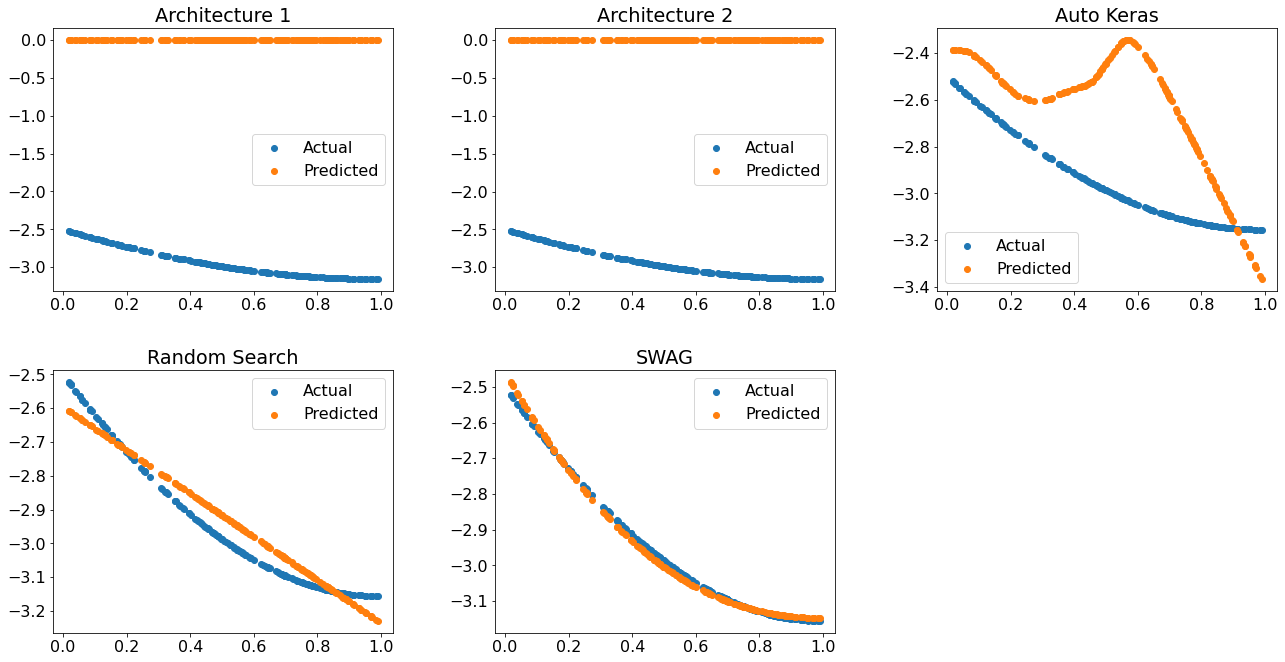

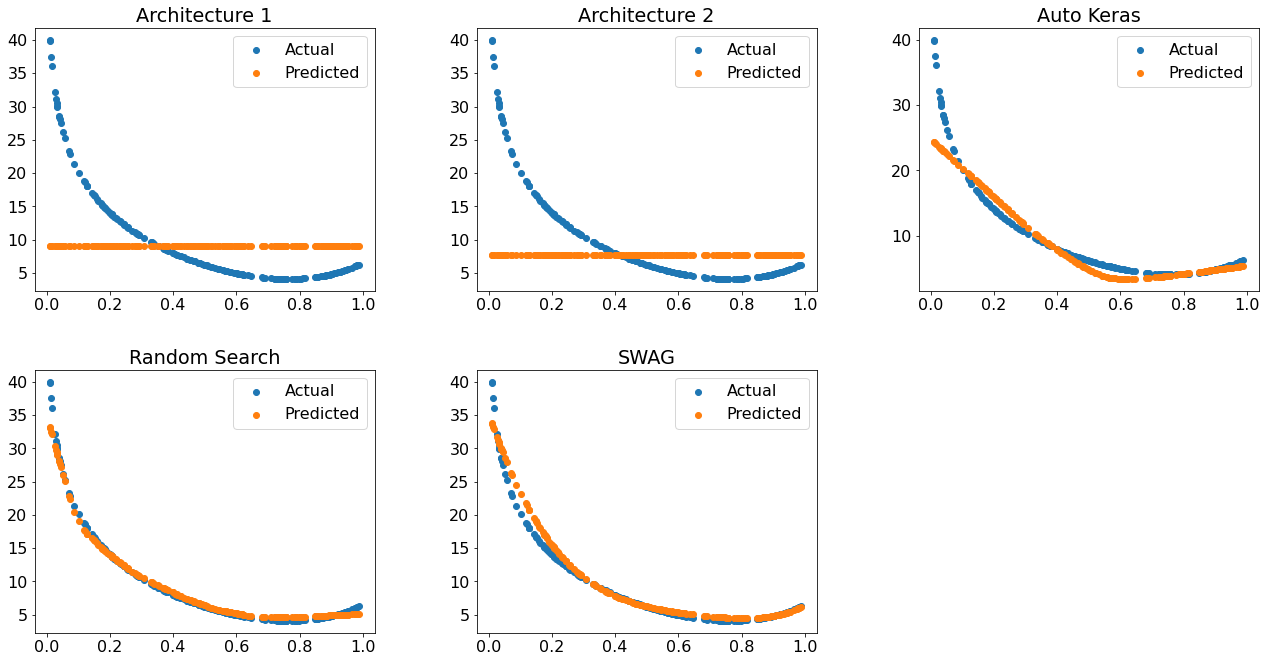

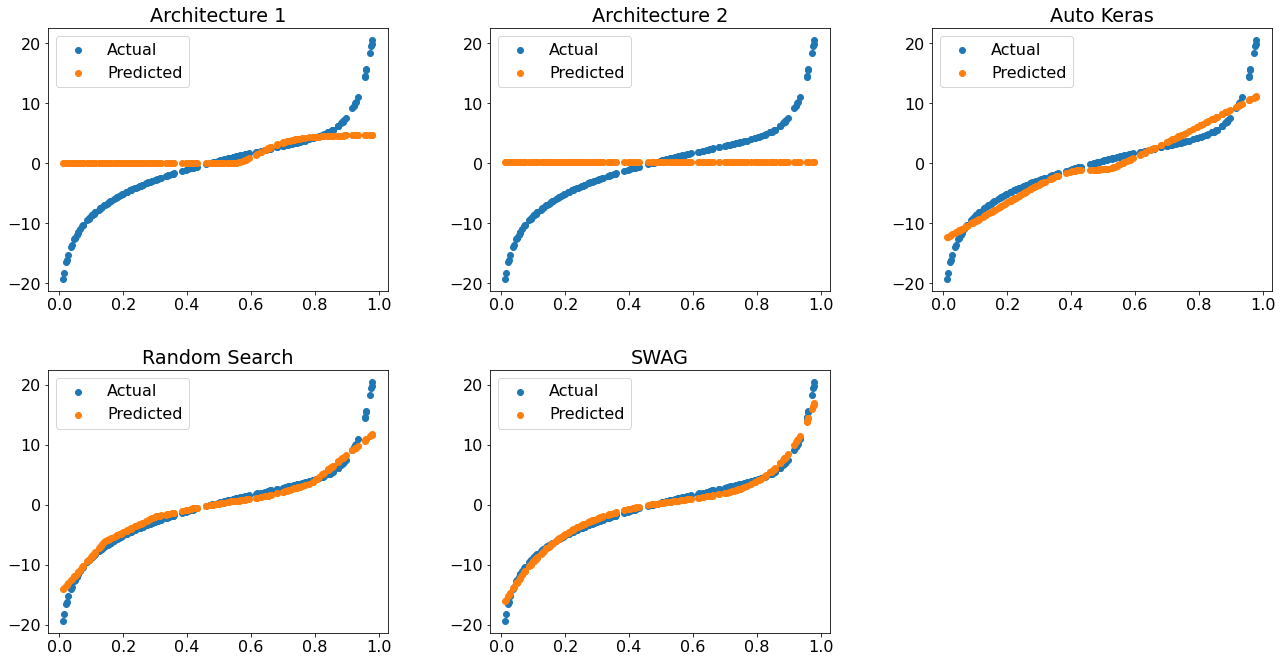

In [27]:
visualize_predictions([F_1_archicture_1, F_1_archicture_2, F_1_autokeras, F_1_Search, F_1_our_model],
                      ['Architecture 1', 'Architecture 2', 'Auto Keras', 'Random Search', 'SWAG'])

visualize_predictions([F_2_archicture_1, F_2_archicture_2, F_2_autokeras, F_2_Search, F_2_our_model],
                      ['Architecture 1', 'Architecture 2', 'Auto Keras', 'Random Search', 'SWAG'])

visualize_predictions([F_3_archicture_1, F_3_archicture_2, F_3_autokeras, F_3_Search, F_3_our_model],
                      ['Architecture 1', 'Architecture 2', 'Auto Keras', 'Random Search', 'SWAG'])



In [28]:
import random

def generate_random_coefficients():
    """
    Generate a list of random coefficients for the function generator.
    """
    coefficients = [None for _ in range(8)]
    coefficients[0] = random.randint(-10, 10)
    coefficients[2] = random.randint(-10, 10)
    coefficients[4] = random.randint(-10, 10)
    coefficients[6] = random.randint(-10, 10)
    coefficients[1] = random.randint(1, 10)
    coefficients[3] = random.randint(1, 10)
    coefficients[5] = random.randint(1, 10)
    coefficients[7] = random.randint(1, 10)
    
    return coefficients


def function_generator(coefficients, x):
    """
    Generate the output of a function with the given coefficients and input value x.
    
    :param coefficients: list, coefficients for the function
    :param x: float, input value for the function
    :return: float, output value of the function
    """
    return (coefficients[0] * power(x, coefficients[1]) +
            coefficients[2] * sigmoid_array(coefficients[3] * x) +
            coefficients[4] * exp(coefficients[5] * x * 0.01) +
            coefficients[6] * log(coefficients[7] * x))


# Loop 10 times to generate Y1 values for different coefficient sets


*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  0
coefficients are [-5, 7, 1, 6, -4, 9, 1, 4]
Run Time : 10.556204
7/7 [==============================] - 0s 2ms/step


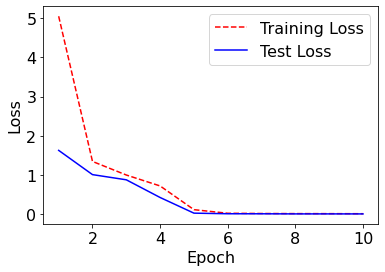

7/7 [==============================] - 0s 2ms/step


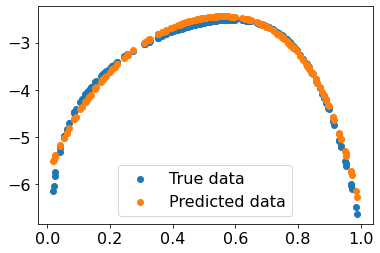

Run Time : 11.246974
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  0
Run Time : 3.518869
7/7 [==============================] - 0s 2ms/step


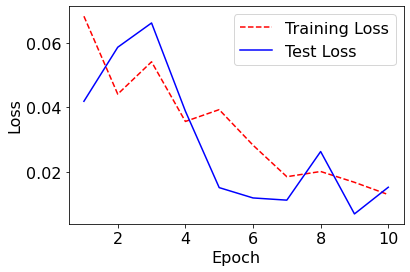

7/7 [==============================] - 0s 2ms/step


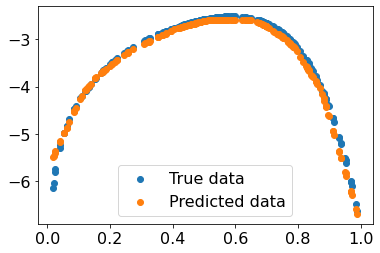

Run Time : 53.645036
*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  1
coefficients are [-4, 10, 1, 4, 5, 4, 7, 3]
Run Time : 5.783005
7/7 [==============================] - 0s 2ms/step


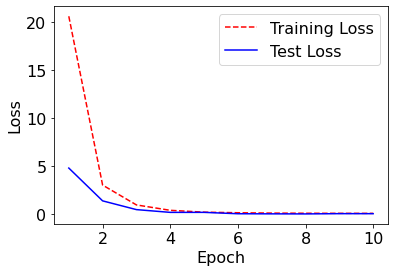

7/7 [==============================] - 0s 2ms/step


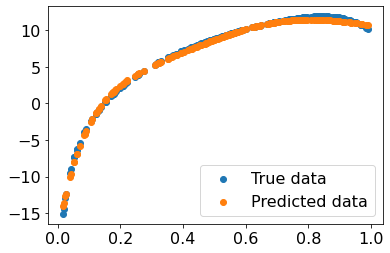

Run Time : 6.421304
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  1
Run Time : 3.961146
7/7 [==============================] - 0s 2ms/step


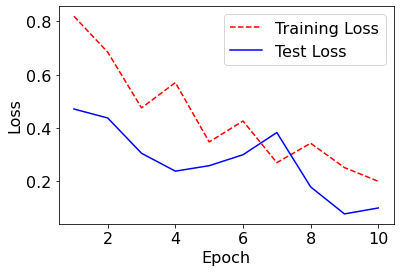

7/7 [==============================] - 0s 2ms/step


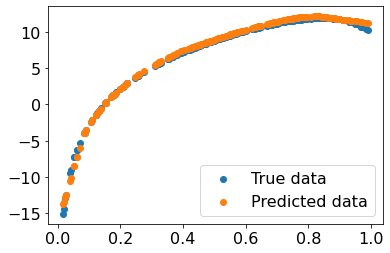

Run Time : 54.024594
*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  2
coefficients are [-1, 6, 2, 7, -1, 8, 5, 7]
Run Time : 5.600621
7/7 [==============================] - 0s 2ms/step


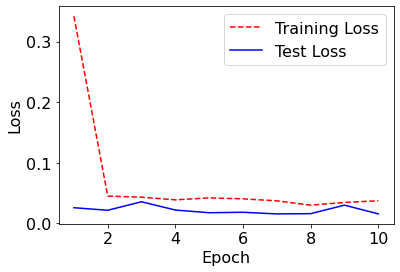

7/7 [==============================] - 0s 2ms/step


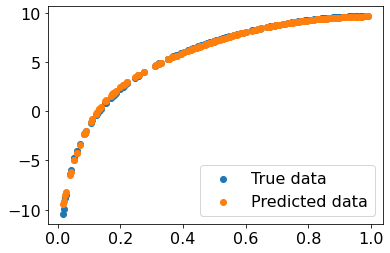

Run Time : 6.235494
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  2
Run Time : 3.944692
7/7 [==============================] - 0s 2ms/step


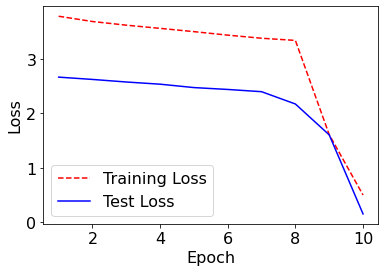

7/7 [==============================] - 0s 2ms/step


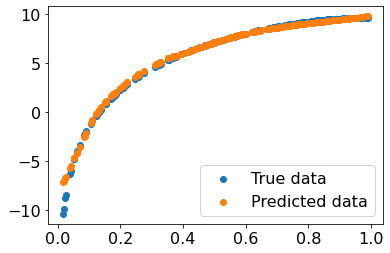

Run Time : 54.842228
*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  3
coefficients are [-3, 10, 5, 2, -8, 1, 3, 6]
Run Time : 5.420660
7/7 [==============================] - 0s 2ms/step


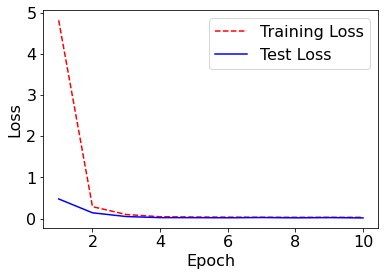

7/7 [==============================] - 0s 2ms/step


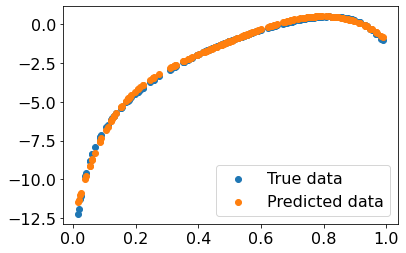

Run Time : 6.007149
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  3
Run Time : 3.842714
7/7 [==============================] - 0s 2ms/step


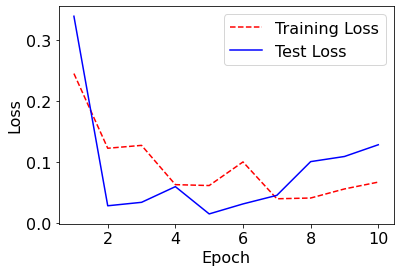

7/7 [==============================] - 0s 2ms/step


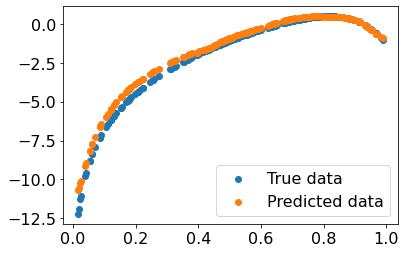

Run Time : 59.201801
*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  4
coefficients are [10, 6, -2, 4, -8, 9, 6, 7]
Run Time : 5.394543
7/7 [==============================] - 0s 2ms/step


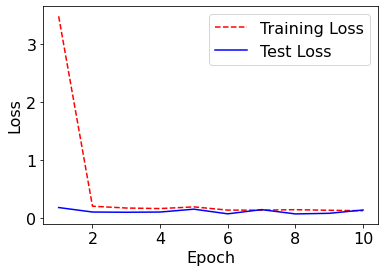

7/7 [==============================] - 0s 2ms/step


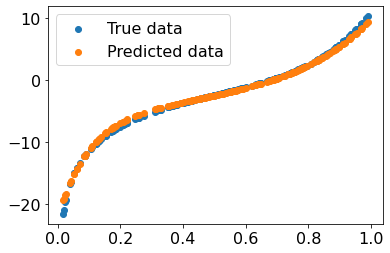

Run Time : 5.970370
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  4
Run Time : 3.290182
7/7 [==============================] - 0s 2ms/step


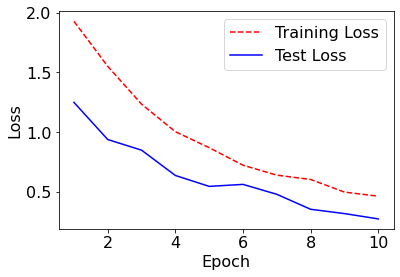

7/7 [==============================] - 0s 2ms/step


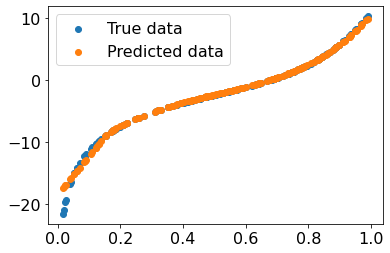

Run Time : 49.045277
*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  5
coefficients are [8, 9, 5, 8, 1, 9, 3, 7]
Run Time : 5.220290
7/7 [==============================] - 0s 2ms/step


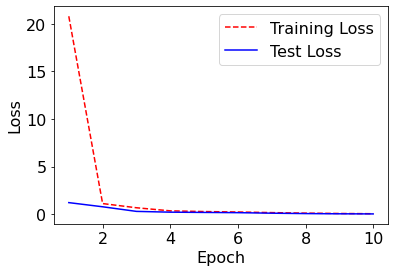

7/7 [==============================] - 0s 2ms/step


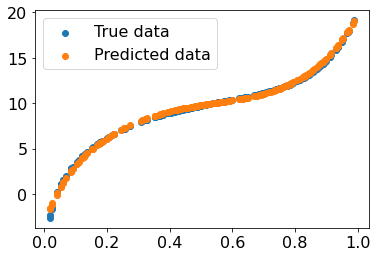

Run Time : 5.834186
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  5
Run Time : 3.674802
7/7 [==============================] - 0s 2ms/step


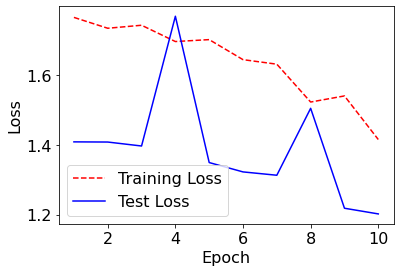

7/7 [==============================] - 0s 2ms/step


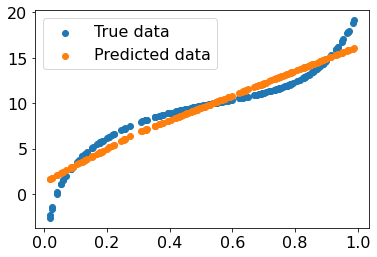

Run Time : 51.923350
*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  6
coefficients are [-8, 8, -9, 1, 9, 5, 10, 2]
Run Time : 5.142217
7/7 [==============================] - 0s 2ms/step


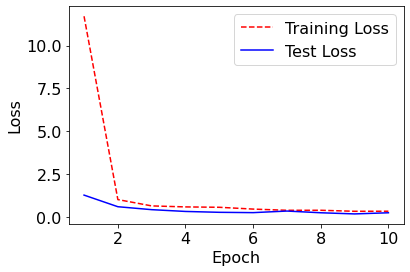

7/7 [==============================] - 0s 2ms/step


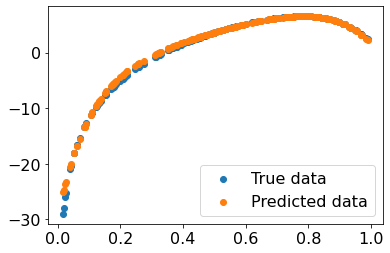

Run Time : 5.704294
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  6
Run Time : 3.237693
7/7 [==============================] - 0s 2ms/step


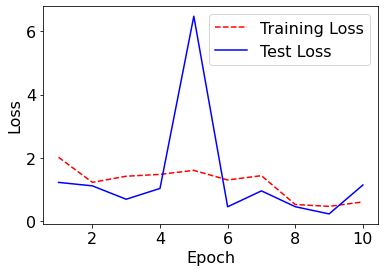

7/7 [==============================] - 0s 2ms/step


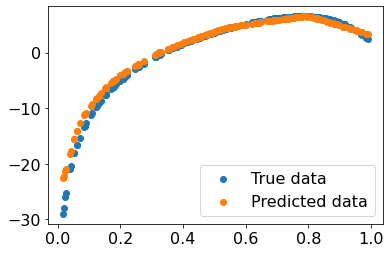

Run Time : 47.728108
*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  7
coefficients are [6, 10, 8, 5, -3, 1, -10, 2]
Run Time : 5.232834
7/7 [==============================] - 0s 2ms/step


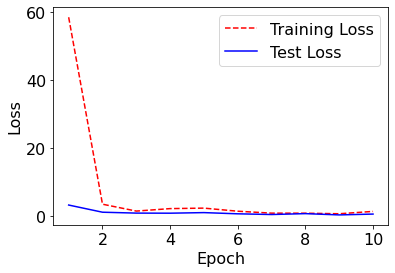

7/7 [==============================] - 0s 2ms/step


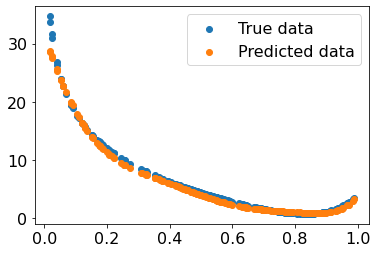

Run Time : 5.775210
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  7
Run Time : 3.258864
7/7 [==============================] - 0s 2ms/step


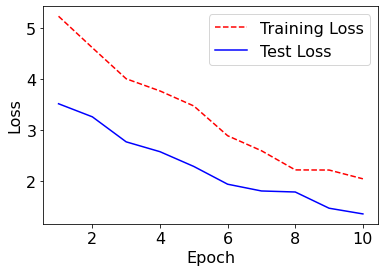

7/7 [==============================] - 0s 2ms/step


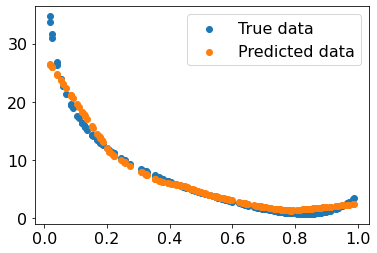

Run Time : 48.339387
*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  8
coefficients are [5, 5, 10, 6, -2, 4, -1, 8]
Run Time : 5.156466
7/7 [==============================] - 0s 2ms/step


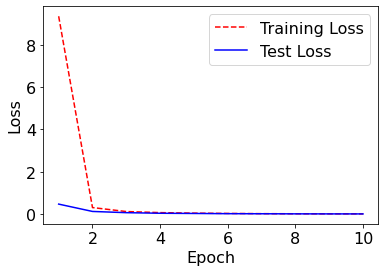

7/7 [==============================] - 0s 2ms/step


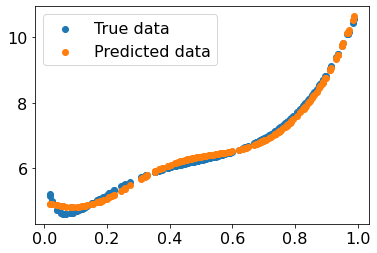

Run Time : 5.700148
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  8
Run Time : 3.755074
7/7 [==============================] - 0s 2ms/step


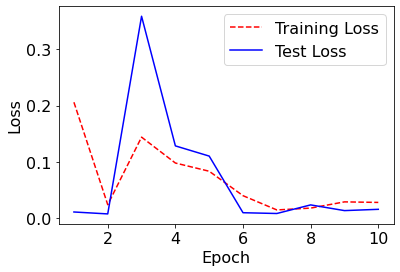

7/7 [==============================] - 0s 2ms/step


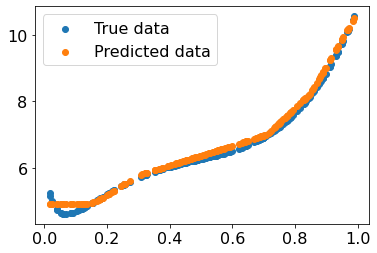

Run Time : 48.430646
*******************************************************************************************
*******************************************************************************************
*******************************************************************************************
SWAG for random Function  9
coefficients are [-7, 10, -6, 5, 7, 1, 4, 10]
Run Time : 5.049783
7/7 [==============================] - 0s 2ms/step


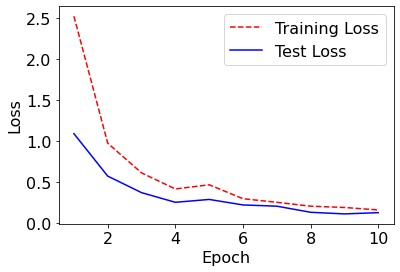

7/7 [==============================] - 0s 2ms/step


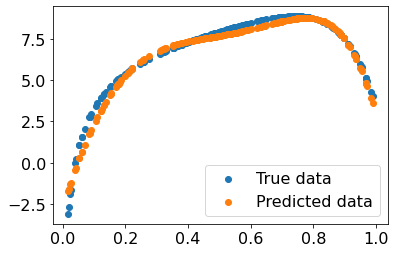

Run Time : 5.632270
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
*******************************************************************************************
AutoKeras for random Function  9
Run Time : 3.973227
7/7 [==============================] - 0s 2ms/step


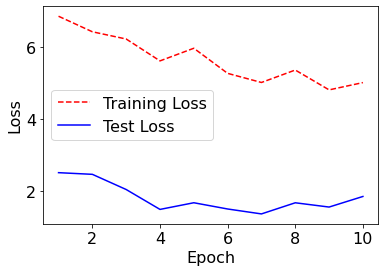

7/7 [==============================] - 0s 2ms/step


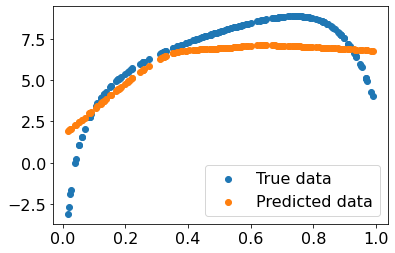

Run Time : 53.135546


In [29]:
activations = ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8']

# Create the SWAG model
model = create_swag_model(input_dim, hidden_dim , output_dim, activations)
hidden_dimention = 50
number_epo=10
# Our_model=create_optimized_model(input_dim,hidden_dim ,output_dim)
Our_model = create_swag_model(input_dim, hidden_dim , output_dim, activations)

list_history=[]
for kk in range(10):  
  coefficients = generate_random_coefficients()
  X1 = X[:, 0]
  Y1 = function_generator(coefficients, X1)

  X_train,X_test,Y_train,Y_test=train_test_split(X1,Y1,test_size=0.2,random_state=1234)
  # coefficient=generate_random_coefficients()
  start = timeit.default_timer()
  print("*******************************************************************************************")
  print("*******************************************************************************************")
  print("*******************************************************************************************")

  print("SWAG for random Function ",kk)
  print("coefficients are",coefficients )
  SWAG_history = train_and_visualize_model(Our_model,X_train,Y_train,X_test,Y_test,number_epo,10)
  list_history.append(SWAG_history)
  end = timeit.default_timer()
  print("Run Time : %f" % (end-start))
  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

  # Reshape data
  X_train = X_train.reshape(800, 1)
  Y_train = Y_train.reshape(800, 1)
  X_test = X_test.reshape(200, 1)
  Y_test = Y_test.reshape(200, 1)

  train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
  test_set = tf.data.Dataset.from_tensor_slices(
      (X_test, Y_test)
  )

  start = timeit.default_timer()

  print("*******************************************************************************************")

  print("AutoKeras for random Function ",kk)
  clf = ak.StructuredDataRegressor(
      overwrite=True, max_trials=10
  ) 
  # Feed the tensorflow Dataset to the classifier.
  clf.fit(train_set, epochs=number_epo,verbose=0)
  autokeras_model=clf.export_model()

  auto_history = train_and_visualize_model(autokeras_model,X_train,Y_train,X_test,Y_test,number_epo,10)
  list_history.append(auto_history)
  end = timeit.default_timer()
  print("Run Time : %f" % (end-start))


In [30]:
def round_loss_values(loss_history, num_digits=3):
    return [round(value, num_digits) for value in loss_history]

rounded_losses = []
for i in range(len(list_history)):
    current_history = list_history[i][3]
    loss_values = current_history.history['loss']
    rounded_values = round_loss_values(loss_values)
    rounded_losses.append(rounded_values)
    # loss_values = current_history.history['val_loss']
    # rounded_values = round_loss_values(loss_values)
    # rounded_losses.append(rounded_values)

for i in range(len(rounded_losses)):
    print(rounded_losses[i])

[5.043, 1.349, 1.004, 0.726, 0.122, 0.031, 0.025, 0.022, 0.021, 0.02]
[0.068, 0.044, 0.054, 0.036, 0.039, 0.028, 0.019, 0.02, 0.017, 0.013]
[20.567, 3.051, 0.992, 0.432, 0.24, 0.18, 0.143, 0.128, 0.12, 0.116]
[0.82, 0.685, 0.476, 0.571, 0.348, 0.427, 0.27, 0.343, 0.252, 0.2]
[0.342, 0.045, 0.043, 0.039, 0.042, 0.04, 0.037, 0.03, 0.034, 0.037]
[3.788, 3.691, 3.623, 3.565, 3.504, 3.44, 3.383, 3.343, 1.611, 0.501]
[4.827, 0.289, 0.098, 0.044, 0.037, 0.034, 0.031, 0.031, 0.029, 0.03]
[0.246, 0.123, 0.128, 0.063, 0.062, 0.1, 0.04, 0.041, 0.056, 0.067]
[3.485, 0.199, 0.167, 0.158, 0.187, 0.131, 0.13, 0.139, 0.128, 0.121]
[1.928, 1.55, 1.233, 1.002, 0.868, 0.721, 0.638, 0.602, 0.496, 0.462]
[20.787, 1.112, 0.673, 0.349, 0.274, 0.227, 0.163, 0.108, 0.071, 0.047]
[1.767, 1.735, 1.744, 1.697, 1.703, 1.645, 1.632, 1.523, 1.541, 1.416]
[11.712, 1.006, 0.637, 0.578, 0.556, 0.451, 0.381, 0.382, 0.322, 0.326]
[2.016, 1.222, 1.416, 1.475, 1.601, 1.298, 1.434, 0.521, 0.461, 0.604]
[58.574, 3.508, 1.479

In [31]:
batch_size = 128
num_classes = 10
epochs = 4

# Load the MNIST data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the input data
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# Convert input data to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Add 10 to input data
x_train += 10
x_test += 10

# Normalize input data
x_train /= 300
x_test /= 300

# Print the number of train and test samples
print(f'{x_train.shape[0]} train samples')
print(f'{x_test.shape[0]} test samples')

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Set the number of train and test samples
num_train_samples = 60000
num_test_samples = 10000

# Select the required number of train and test samples
x_train = x_train[:num_train_samples, :]
x_test = x_test[:num_test_samples, :]

y_train = y_train[:num_train_samples]
y_test = y_test[:num_test_samples]


11490434/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


Epoch 1/4
469/469 [==============================] - 2s 4ms/step - loss: 0.0552 - accuracy: 0.8909 - val_loss: 0.0172 - val_accuracy: 0.9601
Epoch 2/4
469/469 [==============================] - 2s 3ms/step - loss: 0.0152 - accuracy: 0.9677 - val_loss: 0.0138 - val_accuracy: 0.9706
Epoch 3/4
469/469 [==============================] - 2s 3ms/step - loss: 0.0117 - accuracy: 0.9784 - val_loss: 0.0118 - val_accuracy: 0.9757
Epoch 4/4
469/469 [==============================] - 2s 3ms/step - loss: 0.0099 - accuracy: 0.9836 - val_loss: 0.0104 - val_accuracy: 0.9770
Training time: 7.328699608000079
Test loss: 0.010425951331853867
Test accuracy: 0.9769999980926514


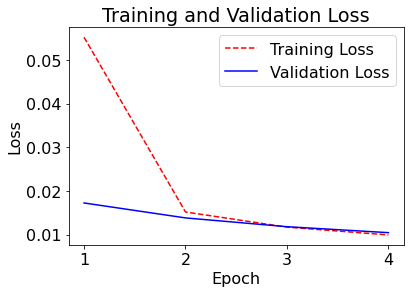

[0.05520525202155113, 0.015161027200520039, 0.01169299054890871, 0.009908550418913364]
[0.017230527475476265, 0.013805525377392769, 0.01179197896271944, 0.01042596623301506]


In [32]:
import keras
# Our optimized model
hidden_dim = 500
model = Sequential()

# Define input layer
input_layer = Input(shape=(784,))

# Define first hidden layer
layer_1_x1 = Dense(hidden_dim, activation='X_1')(input_layer)
layer_1_x2 = Dense(hidden_dim, activation='X_2')(input_layer)

# Concatenate first layer
concat_first_layer = concatenate([layer_1_x1, layer_1_x2])

# Define second hidden layer
layer_x3_x4 = Dense(hidden_dim, activation='X_2_')(concat_first_layer)

# Concatenate second layer
concat_second_layer = concatenate([layer_1_x1, layer_1_x2, concat_first_layer, layer_x3_x4])

# Define output layers
output_first_layer = Dense(hidden_dim, activation='linear')(concat_second_layer)
output_layer = Dense(10, activation='linear')(output_first_layer)

# Create and compile the model
model = Model(input_layer, output_layer)
# model.summary()

# Define the optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

# Measure training time
start = timeit.default_timer()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
end = timeit.default_timer()

print(f'Training time: {end - start}')

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

# Plot the training history
plot__(history)
print(history.history['loss'])
print(history.history['val_loss'])

In [38]:
"""
Trains an AutoKeras StructuredDataClassifier and evaluates its performance.

:param x_train: array-like, training input data
:param y_train: array-like, training output data (labels)
:param x_test: array-like, test input data
:param y_test: array-like, test output data (labels)
"""
# Record the start time
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_set = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)
  )
start_time = timeit.default_timer()

# Create an AutoKeras StructuredDataClassifier with specified parameters
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=3)

# Train the classifier on the input data
clf.fit(train_set, epochs=epochs , verbose=1, batch_size=batch_size)

# Evaluate the classifier's performance
scores = clf.evaluate(x_test, y_test, verbose=0)
print("Start..")
# Record the end time
end_time = timeit.default_timer()

# Calculate and print the run time
print("Run Time: %f" % (end_time - start_time))
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])




Trial 3 Complete [00h 18m 08s]
val_accuracy: 0.8708726167678833

Best val_accuracy So Far: 0.8708726167678833
Total elapsed time: 00h 53m 25s
Epoch 1/4
469/469 [==============================] - 46s 71ms/step - loss: 0.9091 - accuracy: 0.7117
Epoch 2/4
469/469 [==============================] - 33s 70ms/step - loss: 0.4648 - accuracy: 0.8554
Epoch 3/4
469/469 [==============================] - 33s 70ms/step - loss: 0.3798 - accuracy: 0.8816
Epoch 4/4
469/469 [==============================] - 33s 70ms/step - loss: 0.3321 - accuracy: 0.8959
Start..
Run Time: 5681.162174
Test loss: 103.17284393310547
Test accuracy: 0.864799976348877


Epoch 1/4
469/469 [==============================] - 62s 105ms/step - loss: 0.3001 - accuracy: 0.9061 - val_loss: 97.3062 - val_accuracy: 0.8789
Epoch 2/4
469/469 [==============================] - 42s 90ms/step - loss: 0.2683 - accuracy: 0.9155 - val_loss: 99.5540 - val_accuracy: 0.8803
Epoch 3/4
469/469 [==============================] - 42s 90ms/step - loss: 0.2468 - accuracy: 0.9218 - val_loss: 119.5997 - val_accuracy: 0.8774
Epoch 4/4
469/469 [==============================] - 42s 90ms/step - loss: 0.2251 - accuracy: 0.9297 - val_loss: 116.4989 - val_accuracy: 0.8838
[0.3001376688480377, 0.26834431290626526, 0.24675090610980988, 0.22514811158180237]
[97.30615997314453, 99.55400848388672, 119.59966278076172, 116.49888610839844]


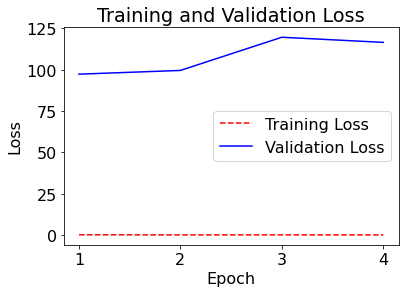

[103.17284393310547, 0.864799976348877]


In [39]:
autokeras_model = clf.export_model()
auto_history = autokeras_model.fit(x_train, y_train, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(x_test, y_test))

print(auto_history.history['loss'])
print(auto_history.history['val_loss'])
plot__(auto_history)
print(scores)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# %%shell
# jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Chapter_2.ipynb"

# path = '/content/drive/MyDrive/Colab Notebooks/Chapter_2.html'

# from google.colab import files
# files.download(path)